https://www.kaggle.com/competitions/2021-ml100marathon-midterm/overview

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
import warnings
  
warnings.filterwarnings('ignore')
plt.style.use("ggplot")

### Read Data

In [18]:
train_df = pd.read_csv("data/train_data.csv")
test_df = pd.read_csv("data/test_features.csv")

print('train: ', train_df.shape)
print('test: ', test_df.shape)
train_df.columns

train:  (113, 22)
test:  (33, 21)


Index(['name', 'bonus', 'deferral_payments', 'deferred_income',
       'director_fees', 'email_address', 'exercised_stock_options', 'expenses',
       'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi',
       'loan_advances', 'long_term_incentive', 'other', 'poi',
       'restricted_stock', 'restricted_stock_deferred', 'salary',
       'shared_receipt_with_poi', 'to_messages', 'total_payments',
       'total_stock_value'],
      dtype='object')

In [19]:
x_train = train_df.drop(columns=["name", "poi"])
y_train = train_df["poi"]

x_test = test_df.drop(columns=["name"])
submit_id = test_df["name"].values

print('train: ', x_train.shape)
print('test: ', x_test.shape)
x_train.info()

train:  (113, 20)
test:  (33, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   bonus                      61 non-null     float64
 1   deferral_payments          28 non-null     float64
 2   deferred_income            34 non-null     float64
 3   director_fees              13 non-null     float64
 4   email_address              83 non-null     object 
 5   exercised_stock_options    81 non-null     float64
 6   expenses                   73 non-null     float64
 7   from_messages              65 non-null     float64
 8   from_poi_to_this_person    65 non-null     float64
 9   from_this_person_to_poi    65 non-null     float64
 10  loan_advances              2 non-null      float64
 11  long_term_incentive        49 non-null     float64
 12  other                      69 non-null     float64
 13  restricted_stock

### Data Preprocessing

In [20]:
# convert column email_address (string) into column own_email (0/1)
def convert_col_email_address(df):
    df.loc[df['email_address'].isnull(), 'own_email'] = 0
    df.loc[~df['email_address'].isnull(), 'own_email'] = 1
    return df.drop(columns='email_address')

x_train = convert_col_email_address(x_train)
x_test = convert_col_email_address(x_test)

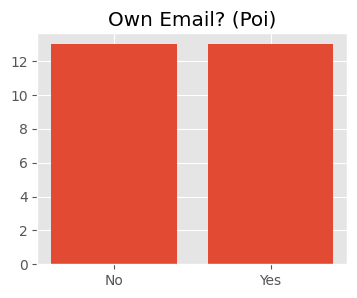

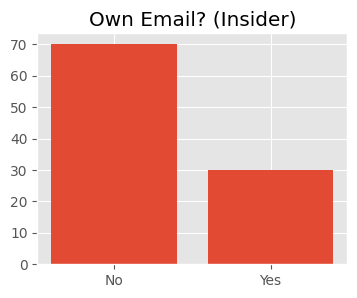

In [21]:
plt.figure(figsize=(4, 3))
plt.bar(['No', 'Yes'], x_train.loc[y_train, 'own_email'].value_counts())
plt.title("Own Email? (Poi)")
plt.show()

plt.figure(figsize=(4, 3))
plt.bar(['No', 'Yes'], x_train.loc[~y_train, 'own_email'].value_counts())
plt.title("Own Email? (Insider)")
plt.show()

### EDA

In [ ]:
# left: density, right: box plot
for feature in x_train.columns:
    plt.figure(figsize=(3, 3))
    plt.subplot(1,2,1)
    sns.distplot(x_train[feature])
    plt.ylabel('Density')
    plt.subplot(1,2,2)
    x_train[feature].plot(kind='box')
    plt.tight_layout()
    plt.show()

### 填補缺失值

In [28]:
# payments category
payment_cols = ["salary", "bonus", "long_term_incentive", "deferred_income", "deferral_payments",
               "loan_advances", "other", "expenses", "director_fees"]

x_train[payment_cols] = x_train[payment_cols].fillna(0)
x_train["total_payments"] = x_train[payment_cols].sum(axis=1)

x_test[payment_cols] = x_test[payment_cols].fillna(0)
x_test["total_payments"] = x_test[payment_cols].sum(axis=1)

In [29]:
# stock category
stock_cols = ["exercised_stock_options", "restricted_stock", "restricted_stock_deferred"]

x_train[stock_cols] = x_train[stock_cols].fillna(0)
x_train["total_stock_value"] = x_train[stock_cols].sum(axis=1)

x_test[stock_cols] = x_test[stock_cols].fillna(0)
x_test["total_stock_value"] = x_test[stock_cols].sum(axis=1)

In [31]:
# communication category
commu_cols = ["to_messages", "from_poi_to_this_person", "from_messages",
              "from_this_person_to_poi", "shared_receipt_with_poi"]

imp_mean = SimpleImputer(strategy='median').set_output(transform="pandas")
x_train[commu_cols] = imp_mean.fit_transform(x_train[commu_cols])
x_test[commu_cols] = imp_mean.transform(x_test[commu_cols])

### 新特徵

In [33]:
# create new finance column 
x_train["total_finance"] = x_train["total_payments"] + x_train["total_stock_value"]
x_test["total_finance"] = x_test["total_payments"] + x_test["total_stock_value"]

### 極端值

### 標準化

In [34]:
scaler = StandardScaler().set_output(transform="pandas")
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

### Feature Selection

<Axes: ylabel='Feature'>

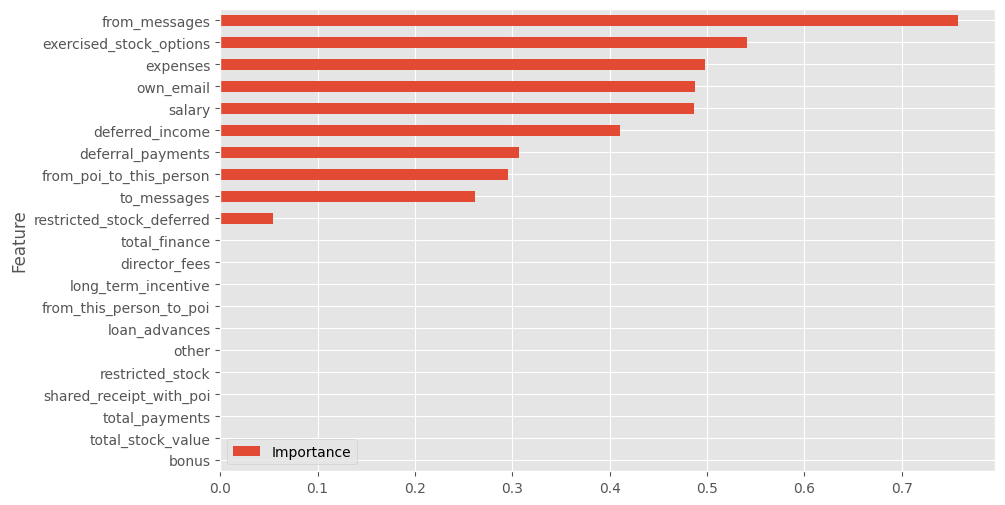

In [35]:
lr = LogisticRegression(penalty='l1', C=1, solver='liblinear', random_state=42)
lr.fit(x_train, y_train)
coefficients = lr.coef_[0]

feature_importance = pd.DataFrame({'Feature': x_train.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [39]:
selected_features = feature_importance.loc[:10,'Feature'].values

### Logistic Regression

In [60]:
lr = LogisticRegression(solver='liblinear')

penalty = ['l1', 'l2']
C = [0.001, 0.01, 0.1, 1, 10, 100]

param_grid = dict(penalty=penalty, C=C)

grid_search = GridSearchCV(lr, param_grid, scoring="accuracy", n_jobs=-1, verbose=1)
grid_result = grid_search.fit(x_train, y_train)
print("Best accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best accuracy: 0.885375 using {'C': 0.001, 'penalty': 'l1'}


In [62]:
lr_best = LogisticRegression(penalty=grid_result.best_params_['penalty'],
                                 C=grid_result.best_params_['C'], solver='liblinear')
print("Acc: ", np.mean(cross_val_score(lr_best, x_train, y_train, cv=10)))

Acc:  0.8863636363636364


In [63]:
lr_best.fit(x_train, y_train)
y_pred_lr = lr_best.predict_proba(x_test)

sub = pd.DataFrame({'name': submit_id, 'poi': y_pred_lr[:, 1]})
sub.to_csv('output/lr_output.csv', index=False)

### SVM

In [57]:
svc = SVC()

kernel = ['linear', 'poly', 'rbf']
degree = [1, 2, 3]
C = [0.001, 0.01, 0.1, 1, 10, 100]

param_grid = dict(kernel=kernel, degree=degree, C=C)

grid_search = GridSearchCV(svc, param_grid, scoring="accuracy", n_jobs=-1, verbose=1)
grid_result = grid_search.fit(x_train, y_train)
print("Best accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best accuracy: 0.902767 using {'C': 1, 'degree': 3, 'kernel': 'poly'}


In [58]:
svc_best = SVC(kernel=grid_result.best_params_['kernel'], degree=grid_result.best_params_['degree'],
               C=grid_result.best_params_['C'], probability=True)
print("Acc: ", np.mean(cross_val_score(svc_best, x_train, y_train, cv=5)))

Acc:  0.9027667984189722


In [59]:
svc_best.fit(x_train, y_train)
y_pred_svc = svc_best.predict_proba(x_test)

sub = pd.DataFrame({'name': submit_id, 'poi': y_pred_svc[:, 1]})
sub.to_csv('output/svc_output.csv', index=False)
# 0.59285

### Random Forest

In [50]:
rfc = RandomForestClassifier(random_state=42)

n_estimators = [100, 200, 300, 400, 500]
max_depth = [5, 10, 15, 20]

param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)

grid_search = GridSearchCV(rfc, param_grid, scoring="accuracy", n_jobs=-1, verbose=1)
grid_result = grid_search.fit(x_train, y_train)
print("Best accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best accuracy: 0.902372 using {'max_depth': 5, 'n_estimators': 100}


In [52]:
rfc_best = RandomForestClassifier(n_estimators=grid_result.best_params_['n_estimators'],
               max_depth=grid_result.best_params_['max_depth'])
print("Acc: ", np.mean(cross_val_score(rfc_best, x_train, y_train, cv=5)))

Acc:  0.8936758893280633


In [53]:
rfc_best.fit(x_train, y_train)
y_pred_rfc = rfc_best.predict_proba(x_test)

sub = pd.DataFrame({'name': submit_id, 'poi': y_pred_rfc[:, 1]})
sub.to_csv('output/rfc_output.csv', index=False)
# 0.77142

<Axes: ylabel='Feature'>

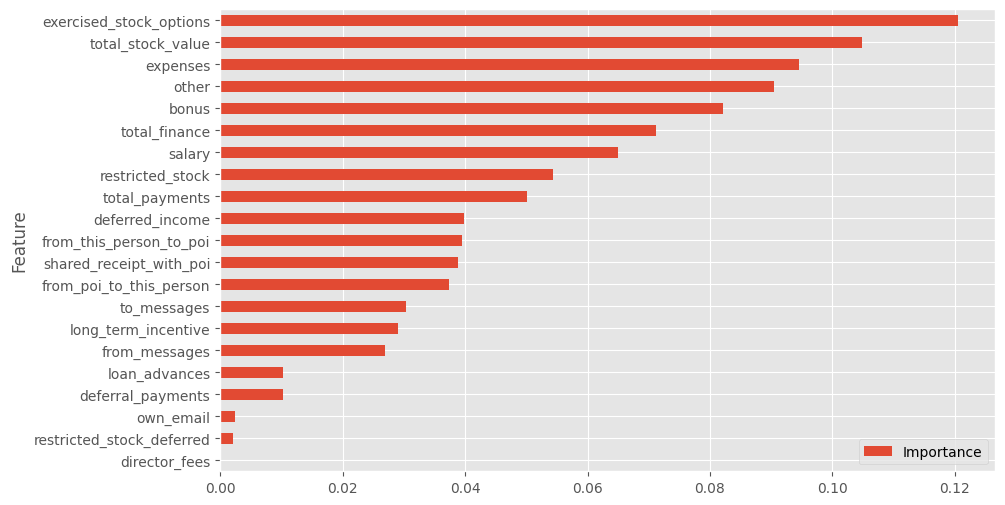

In [67]:
feature_importance = pd.DataFrame({'Feature': x_train.columns, 
                                   'Importance': rfc_best.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

### Gradient Boosting Machine

In [54]:
gbc = GradientBoostingClassifier(random_state=42)

learning_rate = [0.001, 0.01, 0.1, 1]
n_estimators = [100, 200, 300, 400, 500]
max_depth = [5, 10, 15, 20]

param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth)

grid_search = GridSearchCV(gbc, param_grid, scoring="accuracy", n_jobs=-1, verbose=1)
grid_result = grid_search.fit(x_train, y_train)
print("Best accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best accuracy: 0.885375 using {'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 100}


In [55]:
gbc_best = GradientBoostingClassifier(learning_rate=grid_result.best_params_['learning_rate'],
                                      n_estimators=grid_result.best_params_['n_estimators'],
                                      max_depth=grid_result.best_params_['max_depth'])
print("Acc: ", np.mean(cross_val_score(gbc_best, x_train, y_train, cv=5)))

Acc:  0.8853754940711462


In [56]:
gbc_best.fit(x_train, y_train)
y_pred_gbc = gbc_best.predict_proba(x_test)

sub = pd.DataFrame({'name': submit_id, 'poi': y_pred_gbc[:, 1]})
sub.to_csv('output/gbc_output.csv', index=False)
# 0.58928

### Blending

In [64]:
blender = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(penalty='l1', C=0.001, solver='liblinear')),
        ('svc', SVC(kernel='poly', degree=3, C=1, probability=True)),
        ('rfc', RandomForestClassifier(n_estimators=100, max_depth=5)),
        ('gbc', GradientBoostingClassifier(learning_rate=0.001, n_estimators=100, max_depth=5))
        ],
        voting='soft')
print("Acc: ", np.mean(cross_val_score(blender, x_train, y_train, cv=5)))

Acc:  0.8853754940711462


In [65]:
blender.fit(x_train, y_train)
y_pred_blend = blender.predict_proba(x_test)

sub = pd.DataFrame({'name': submit_id, 'poi': y_pred_blend[:, 1]})
sub.to_csv('output/blend_output.csv', index=False)
# 0.76428